<a href="https://colab.research.google.com/github/Abhivarma-Birru-Unt/Abhivarma_INFO5731_Spring2023/blob/main/In_class_exercise_04_03282023_Abhivarma_Birru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/28/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

In [10]:
import nltk; 
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [12]:
# Write your code here
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)




/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
dataFrame_of_text_corpus = pd.read_csv("https://github.com/Abhivarma-Birru-Unt/Abhivarma_INFO5731_Spring2023/blob/main/data.csv")

#Cleaning the data
import re

def text_cleaning(tweets):
    cleaned_text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    cleaned_text = re.sub(r'#[A-Za-z0-9_]+', '', cleaned_text) #removing Hashtag symbols.
    cleaned_text = re.sub(r'RT[\s]+', '', cleaned_text) #removing Retweet symbol (RT).
    cleaned_text = re.sub(r'https?:\/\/\S+', '', cleaned_text) #remove URL's.
    cleaned_text = re.sub(r"www.\S+", "", cleaned_text)
    cleaned_text = re.sub('[()!?]', ' ', cleaned_text)
    cleaned_text = re.sub('\[.*?\]',' ', cleaned_text)
    cleaned_text = re.sub("[^A-Za-z0-9]"," ", cleaned_text)#Filtering non-alphanumeric characters
    cleaned_text = re.sub('\\n', '', cleaned_text)#removing the '\n' character
    cleaned_text = re.sub(r'[0-9]+', '', cleaned_text)#removing numbers
    
    return cleaned_text

dataFrame_of_text_corpus["Text"] = dataFrame_of_text_corpus["Text"].apply(text_cleaning)

# Convert to list
data_List = dataFrame_of_text_corpus.Text.values.tolist()

In [16]:
def sending_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sending_to_words(data_List))

In [17]:
for_bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
for_trigram= gensim.models.Phrases(for_bigram[data_words], threshold=100)  

#This is the Faster way to get a sentence clubbed as a trigram/bigram
bmod = gensim.models.phrases.Phraser(for_bigram)
tmod = gensim.models.phrases.Phraser(for_trigram)

#  trigram example
print(tmod[bmod[data_words[0]]])

['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [18]:
#  Defining the functions for lemmatization, trigrams stopwords and bigrams
def stopwords_removal(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def bigrams_creation(texts):
    return [bmod[doc] for doc in texts]

def trigrams_creation(texts):
    return [tmod[bmod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [19]:
# In this we remove Stop Words
data_words_with_no_stops = stopwords_removal(data_words)

# Form Bigrams
data_with_bigrams = bigrams_creation(data_words_with_no_stops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
lemmatized_data = lemmatization(data_with_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(lemmatized_data[:1])

[['optimistic', 'ability', 'prevent', 'next', 'pandemic', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [20]:
# Here we create required Dictionary from Lemmatized Data
id_to_words = corpora.Dictionary(lemmatized_data)

# Creating the text Corpus
text_for_corpus = lemmatized_data

# Here we term Document Frequency
text_corpus = [id_to_words.doc2bow(text) for text in text_for_corpus]

# View
print(text_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [21]:
id_to_words[5]


'next'

In [23]:
[[(id_to_words[id], freq) for id, freq in t_cp] for t_cp in text_corpus[:1]]


[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('pandemic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [24]:
lda = gensim.models.ldamodel.LdaModel(corpus=text_corpus,
                                           id2word=id_to_words,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


In [25]:
# Printing the Keywords in the 10 topics
print(lda.print_topics())
doc_lda = lda[text_corpus]


[(0, '0.041*"young" + 0.026*"opportunity" + 0.026*"ask" + 0.021*"million" + 0.021*"community" + 0.021*"power" + 0.020*"life" + 0.019*"generation" + 0.019*"question" + 0.018*"worker"'), (1, '0.102*"book" + 0.062*"read" + 0.029*"keep" + 0.021*"conversation" + 0.021*"late" + 0.016*"tackle" + 0.016*"thank" + 0.015*"author" + 0.014*"partnership" + 0.014*"favorite"'), (2, '0.039*"new" + 0.031*"good" + 0.030*"work" + 0.026*"need" + 0.024*"get" + 0.020*"investment" + 0.019*"learn" + 0.019*"help" + 0.019*"global" + 0.018*"important"'), (3, '0.031*"life" + 0.029*"help" + 0.028*"great" + 0.025*"way" + 0.020*"pandemic" + 0.017*"take" + 0.017*"covid" + 0.016*"thing" + 0.015*"even" + 0.014*"well"'), (4, '0.035*"inspire" + 0.027*"work" + 0.023*"year" + 0.022*"live" + 0.021*"change" + 0.017*"government" + 0.016*"save" + 0.016*"meet" + 0.015*"team" + 0.014*"never"'), (5, '0.075*"world" + 0.047*"people" + 0.038*"make" + 0.031*"year" + 0.027*"progress" + 0.023*"health" + 0.020*"country" + 0.020*"day" + 0

In [26]:
# Here we first compute Perplexity
print('Perplexity: ', lda.log_perplexity(text_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda_Model = CoherenceModel(model=lda, texts=lemmatized_data, dictionary=id_to_words, coherence='c_v')
coherence_lda = coherence_lda_Model.get_coherence()
print('Coherence Score: ', coherence_lda)

Perplexity:  -7.412594668358864
Coherence Score:  0.3763135997125201


In [27]:
# Visualing using pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda , text_corpus, id_to_words)
vis


/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.171877  0.262794       1        1  19.133325
2      0.205056 -0.196207       2        1  17.208745
3      0.177264  0.005745       3        1  14.266425
4     -0.176659  0.026600       4        1   9.396337
8     -0.040275  0.132458       5        1   9.064105
6     -0.006168 -0.180057       6        1   8.672361
9     -0.049672 -0.016599       7        1   7.867079
0     -0.073140 -0.048051       8        1   6.811537
1     -0.114332  0.005775       9        1   4.562512
7     -0.093951  0.007541      10        1   3.017576, topic_info=               Term        Freq       Total Category  logprob  loglift
65            world  194.000000  194.000000  Default  30.0000  30.0000
204  climate_change   82.000000   82.000000  Default  29.0000  29.0000
414            book   59.000000   59.000000  Default  28.0000  28.0000
33           people  121.000000  121.000000  Default  27.0000  27.0000
23             year  126.000000  126.000000  Default  26.0000  26.0000
..              ...         ...         ...      ...      ...      ...
869          course    2.035117    2.815841  Topic10  -5.2350   3.1760
767      administer    1.991057    2.771737  Topic10  -5.2569   3.1699
296         develop    4.873391   22.828146  Topic10  -4.3618   1.9565
78          country    4.845324   67.630914  Topic10  -4.3676   0.8647
60             live    3.549758   30.057547  Topic10  -4.6787   1.3645

[421 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
0         9  0.895109      ability
119       2  0.306676   accelerate
119       6  0.690021   accelerate
850      10  0.853211  accelerator
366       9  0.826915       access
...     ...       ...          ...
23        1  0.602441         year
23        4  0.221952         year
23        5  0.174391         year
2155      6  0.846051        yield
175       8  0.988083        young

[457 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 4, 5, 9, 7, 10, 1, 2, 8])

In [28]:
 !pip install gensim==3.8.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip
from gensim import models
from gensim.models.wrappers import LdaMallet
corpus=text_corpus
mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = LdaMallet(mallet_path, corpus = corpus , num_topics=20, id2word=id_to_words)

--2023-04-03 01:13:42--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2023-04-03 01:13:42--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip.10’

mallet-2.0.8.zip.10 100%[===================>]  15.43M  19.7MB/s    in 0.8s    

2023-04-03 01:13:43 (19.7 MB/s) - ‘mallet-2.0.8.zip.10’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
replace mallet-2.0.8/bin/classifier2info? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2cla

In [30]:
# printing the Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=lemmatized_data, dictionary=id_to_words, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score using LDAMallet: ', coherence_ldamallet)

[(0,
  [('health', 0.14612676056338028),
   ('global', 0.1073943661971831),
   ('improve', 0.05985915492957746),
   ('tool', 0.04929577464788732),
   ('system', 0.03873239436619718),
   ('organization', 0.028169014084507043),
   ('commit', 0.028169014084507043),
   ('reach', 0.02112676056338028),
   ('education', 0.02112676056338028),
   ('program', 0.01936619718309859)]),
 (5,
  [('book', 0.1588235294117647),
   ('read', 0.09215686274509804),
   ('lot', 0.08431372549019608),
   ('favorite', 0.047058823529411764),
   ('write', 0.043137254901960784),
   ('great', 0.041176470588235294),
   ('recommend', 0.025490196078431372),
   ('watch', 0.025490196078431372),
   ('history', 0.023529411764705882),
   ('author', 0.021568627450980392)]),
 (1,
  [('good', 0.10465116279069768),
   ('community', 0.05426356589147287),
   ('impact', 0.05426356589147287),
   ('worker', 0.04844961240310078),
   ('congratulation', 0.03488372093023256),
   ('health', 0.029069767441860465),
   ('part', 0.0271317829

In [31]:
def compute_coherence_values_topics(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id_to_words)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values_topics(dictionary=id_to_words, corpus=corpus, texts=lemmatized_data, start=2, limit=40, step=2)


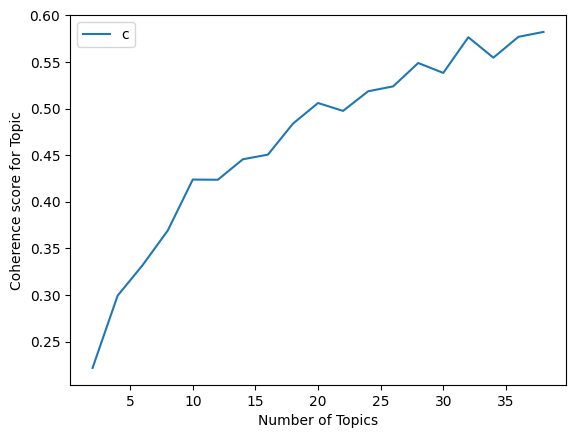

In [34]:
# Visualizing a graph for all the topics and their coherence score using matplotlib
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score for Topic")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))


Num Topics = 2  has Coherence Value of 0.2217
Num Topics = 4  has Coherence Value of 0.2992
Num Topics = 6  has Coherence Value of 0.3321
Num Topics = 8  has Coherence Value of 0.369
Num Topics = 10  has Coherence Value of 0.4238
Num Topics = 12  has Coherence Value of 0.4236
Num Topics = 14  has Coherence Value of 0.4456
Num Topics = 16  has Coherence Value of 0.4506
Num Topics = 18  has Coherence Value of 0.4838
Num Topics = 20  has Coherence Value of 0.506
Num Topics = 22  has Coherence Value of 0.4975
Num Topics = 24  has Coherence Value of 0.5185
Num Topics = 26  has Coherence Value of 0.5238
Num Topics = 28  has Coherence Value of 0.5489
Num Topics = 30  has Coherence Value of 0.5383
Num Topics = 32  has Coherence Value of 0.5765
Num Topics = 34  has Coherence Value of 0.5546
Num Topics = 36  has Coherence Value of 0.577
Num Topics = 38  has Coherence Value of 0.5822


In [36]:
# Select the model and printing the respectivetopics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# We have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(16,
  '0.131*"talk" + 0.101*"foundation" + 0.073*"opportunity" + 0.061*"excite" + '
  '0.058*"government" + 0.055*"recently" + 0.043*"issue" + 0.037*"team" + '
  '0.024*"sit" + 0.021*"turn"'),
 (25,
  '0.114*"progress" + 0.099*"community" + 0.090*"make" + 0.077*"hope" + '
  '0.031*"speak" + 0.031*"action" + 0.028*"include" + 0.025*"hopeful" + '
  '0.022*"sanitation" + 0.022*"ready"'),
 (11,
  '0.101*"avoid" + 0.101*"innovation" + 0.084*"emission" + 0.060*"climate" + '
  '0.048*"climate_disaster" + 0.048*"climate_change" + 0.038*"climate_disast" '
  '+ 0.036*"sector" + 0.034*"carbon" + 0.029*"reduce"'),
 (13,
  '0.299*"world" + 0.047*"breakthrough" + 0.045*"poor" + 0.034*"report" + '
  '0.034*"spread" + 0.031*"face" + 0.028*"fast" + 0.025*"inequity" + '
  '0.022*"part" + 0.022*"outbreak"'),
 (18,
  '0.274*"health" + 0.095*"improve" + 0.067*"worker" + 0.061*"global" + '
  '0.059*"system" + 0.039*"organization" + 0.036*"care" + 0.025*"long" + '
  '0.022*"epidemic" + 0.020*"frontline"'),

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [37]:
# Write your code here


# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt




In [39]:
def data_preprocessing(document_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in document_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
data_preprocessing(data_List)

[['optimist',
  'abil',
  'prevent',
  'next',
  'pandem',
  'learn',
  'much',
  'covid',
  'innov',
  'tremend'],
 ['global',
  'fund',
  'one',
  'best',
  'invest',
  'global',
  'health',
  'fulli',
  'fund',
  'program',
  'next',
  'year',
  'critic',
  'end',
  'hiv',
  'tb',
  'malaria',
  'help',
  'ensur',
  'covid',
  'last',
  'pandem'],
 ['end',
  'day',
  'paul',
  'last',
  'impact',
  'found',
  'patient',
  'love',
  'dearli',
  'peopl',
  'aliv',
  'today',
  'dedic',
  'life',
  'help'],
 ['work',
  'continu',
  'partner',
  'health',
  'incred',
  'organ',
  'co',
  'found',
  'phenomen',
  'legaci'],
 ['paul',
  'never',
  'happier',
  'care',
  'patient',
  'one',
  'clinic',
  'help',
  'creat',
  'heart',
  'goe',
  'famili',
  'friend',
  'colleagu',
  'peopl',
  'whose',
  'live',
  'touch'],
 ['devast',
  'loss',
  'paul',
  'hero',
  'fortun',
  'call',
  'friend',
  'never',
  'known',
  'anyon',
  'passion',
  'reduc',
  'world',
  'worst',
  'inequ',
  '

In [40]:
def corpus_preparation(document_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(document_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in document_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [41]:
number_of_topics=7
words=10


In [42]:
def gensim_lsa_model_creation(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=corpus_preparation(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [43]:
def coherence_values_computation(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [44]:
def graph_plotting(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=corpus_preparation(doc_clean)
    model_list, coherence_values = coherence_values_computation(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

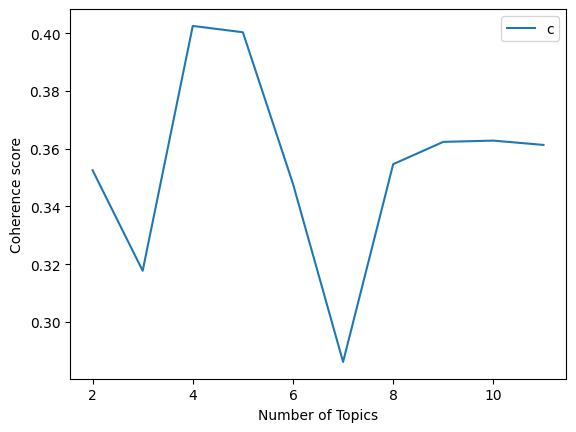

In [45]:
start,stop,step=2,12,1
graph_plotting(data_preprocessing(data_List),start,stop,step)

In [47]:
model=gensim_lsa_model_creation(data_preprocessing(data_List),number_of_topics,words)


[(0, '-0.361*"world" + -0.306*"climat" + -0.235*"work" + -0.221*"chang" + -0.185*"help" + -0.179*"need" + -0.176*"one" + -0.153*"peopl" + -0.152*"year" + -0.143*"make"'), (1, '-0.574*"climat" + -0.376*"chang" + 0.216*"health" + 0.174*"year" + 0.165*"countri" + -0.157*"avoid" + -0.142*"disast" + -0.138*"energi" + -0.129*"need" + 0.127*"vaccin"'), (2, '-0.577*"world" + 0.471*"year" + 0.342*"one" + 0.219*"book" + 0.155*"new" + -0.142*"health" + 0.131*"read" + 0.097*"lot" + -0.094*"around" + 0.091*"learn"'), (3, '0.527*"world" + -0.243*"countri" + 0.227*"year" + -0.220*"health" + -0.207*"need" + -0.192*"help" + -0.189*"vaccin" + -0.188*"pandem" + 0.151*"one" + -0.148*"covid"'), (4, '0.638*"work" + -0.331*"one" + 0.214*"year" + -0.203*"help" + 0.193*"health" + -0.169*"peopl" + -0.150*"new" + -0.149*"world" + -0.103*"diseas" + 0.101*"foundat"'), (5, '0.306*"chang" + -0.283*"make" + -0.262*"energi" + -0.262*"new" + 0.245*"one" + 0.229*"climat" + 0.219*"peopl" + 0.173*"countri" + -0.171*"zero"

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [49]:
# Write your code here
import pyLDAvis
pyLDAvis.enable_notebook()
!pip install lda2vec


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for lda2vec: filename=lda2vec-0.16.10-py3-none-any.whl size=14432 sha256=f8310e45aaf43d2e406bdf3cfc046f6665ca057efca17e38bcf04c3e7ba91373
  Stored in directory: /root/.cache/pip/wheels/fa/ad/6c/38aa944b34a94fd5d4f4d48e7432f94cd97f18d15779bdc9e5
Successfully built lda2vec


In [52]:
from google.colab import files
uploades = files.upload()

Saving topics.pyldavis.npz to topics.pyldavis.npz


In [53]:
npz = np.load(open('/content/topics.pyldavis.npz', 'rb'), allow_pickle=True)
dat = {k: v for (k, v) in npz.iteritems()}
dat['vocab'] = dat['vocab'].tolist()


In [54]:
top_n = 10
topic_to_top_words = {}
for j, topic_to_word in enumerate(dat['topic_term_dists']):
    top = np.argsort(topic_to_word)[::-1][:top_n]
    msg = 'Topic %i '  % j
    top_words = [dat['vocab'][i].strip()[:35] for i in top]
    msg += ' '.join(top_words)
    print(msg)
    topic_to_top_words[j] = top_words

Topic 0 jesus god orthodox faith verse worship belief christianity christian mormon
Topic 1 bike tire honda battery brake ride valve aluminum intake jeep
Topic 2 game team play win baseball score playoff mets goal phillies
Topic 3 shuttle nasa space payload computational planetary satellite mission launch lunar
Topic 4 armenian troop cyprus israel soldier agdam bayonet terror bullet he
Topic 5 drive controller battery dock connector ink card slot pin vram
Topic 6 key encrypt cryptosystem encryption cryptography secure rsa crypto eavesdrop decrypt
Topic 7 ride revolver bike bikers go jeep i dog a tank
Topic 8 homicide gun handgun firearm fbi unconstitutional federal smuggle drug weapon
Topic 9 israel armenian plo cyprus troop lebanese arab palestinian syria turkish
Topic 10 armenian bayonet arena team turkish tartar nhl playoff game defenseman
Topic 11 widget server contrib font editor format mit pixmap toolkit binary
Topic 12 controller card disk bios rom vram drive isa vga trident
Top

In [55]:
import warnings
warnings.filterwarnings('ignore')
prepared_data = pyLDAvis.prepare(dat['topic_term_dists'], dat['doc_topic_dists'], 
                                 dat['doc_lengths'] * 1.0, dat['vocab'], dat['term_frequency'] * 1.0, mds='tsne')

In [56]:
pyLDAvis.display(prepared_data)


In [57]:
from sklearn.datasets import fetch_20newsgroups
remove=('headers', 'footers', 'quotes')
texts = fetch_20newsgroups(subset='train', remove=remove).data


In [58]:
data=pd.DataFrame(texts)


In [59]:
data=data.rename(columns={0:'News_text'})


In [60]:
data['News_text']=data['News_text'].str.lower()


In [61]:
data['News_text'].head()


0    i was wondering if anyone out there could enli...
1    a fair number of brave souls who upgraded thei...
2    well folks, my mac plus finally gave up the gh...
3    \ndo you have weitek's address/phone number?  ...
4    from article <c5owcb.n3p@world.std.com>, by to...
Name: News_text, dtype: object

In [62]:
#Here we remove the numbers from the news text
for letter in '1234567890.(/':
    data['News_text']= data['News_text'].str.replace(letter,'')

In [63]:
#Here we remove the singluar letters (like, "u",'x ,'y','t',"w" etc) from the text
data['News_text']=data['News_text'].str.replace(r'\b\w\b','').str.replace(r'\s+', ' ')


In [64]:
#genereating Tokenization of News
tokenizer = RegexpTokenizer(r'\w+')
data['News_text'] = data['News_text'].apply(tokenizer.tokenize)


In [66]:
stopwords_list = stopwords.words('english')


In [67]:
data['News_text']=data['News_text'].apply(lambda x: [item for item in x if item not in stopwords_list])


In [68]:
data['News_text'].head()


0    [wondering, anyone, could, enlighten, car, saw...
1    [fair, number, brave, souls, upgraded, si, clo...
2    [well, folks, mac, plus, finally, gave, ghost,...
3    [weitek, addressphone, number, like, get, info...
4    [article, cowcbnp, worldstdcom, tombaker, worl...
Name: News_text, dtype: object

In [69]:
#Description of all the news text information
all_words = [word for tokens in data['News_text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in data['News_text']]

VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))


1207033 words total, with a vocabulary size of 88497
Max sentence length is 12910


In [70]:
from collections import Counter
counter = Counter(all_words)
counter.most_common(20)

[('ax', 62452),
 ('one', 6408),
 ('would', 6160),
 ('max', 4598),
 ('people', 4097),
 ('like', 3956),
 ('get', 3532),
 ('know', 3485),
 ('also', 3346),
 ('use', 3173),
 ('think', 3002),
 ('time', 2946),
 ('new', 2594),
 ('us', 2586),
 ('could', 2532),
 ('well', 2493),
 ('good', 2487),
 ('may', 2419),
 ('even', 2290),
 ('two', 2239)]

In [ ]:
counted_words = Counter(all_words)

words = []
counts = []
for letter, count in counted_words.most_common(25):
    words.append(letter)
    counts.append(count)

In [71]:
def topics_LDA(model, num_topics):
    word_dict = {};
    for i in range(num_topics):
        words = model.show_topic(i, topn = 10);
        word_dict['Words of Topic ' + '{:02d}'.format(i+1)] = [i[0] for i in words];
    return pd.DataFrame(word_dict)

In [72]:
data_text=pd.DataFrame(data['News_text'])
data_text=data_text.rename(columns={'News_text':'News_Text'})

In [73]:
train_ = [value[0] for value in data_text.iloc[0:].values]


In [74]:
num_topics = 20


In [75]:
id2word1 = gensim.corpora.Dictionary(train_)


In [76]:
corpus1 = [id2word1.doc2bow(text) for text in train_]


In [77]:
#Call the LDA model and feed the respective calculated text, dictionary and topics
from gensim.models import ldamodel
lda2vec = ldamodel.LdaModel(corpus=corpus1, id2word=id2word1, num_topics=num_topics)

In [78]:
#Calling topics_LDA function and using lda2vec with selective topics
topics_LDA(lda2vec, num_topics)

,Words of Topic 01,Words of Topic 02,Words of Topic 03,Words of Topic 04,Words of Topic 05,Words of Topic 06,Words of Topic 07,Words of Topic 08,Words of Topic 09,Words of Topic 10,Words of Topic 11,Words of Topic 12,Words of Topic 13,Words of Topic 14,Words of Topic 15,Words of Topic 16,Words of Topic 17,Words of Topic 18,Words of Topic 19,Words of Topic 20
0,believers,team,pts,university,one,cx,key,year,scsi,ripem,would,get,entry,ax,one,vs,god,use,car,space
1,steering,hockey,pit,mormon,said,ww,militia,game,drive,encryption,one,information,wire,max,people,la,would,windows,db,moon
2,reminds,nhl,chicago,health,armenians,qs,pgp,one,slave,use,like,data,wiring,gv,would,van,one,system,one,orbit
3,helmet,season,cubs,hicnet,people,ra,number,would,ide,bit,people,may,ground,pl,like,det,people,thanks,engine,launch
4,dos,players,period,cdc,went,mv,amendment,last,master,rider,think,msg,rules,bf,think,bos,us,like,cs,earth
5,physician,ice,pp,aids,armenian,sp,keys,games,drives,data,time,please,neutral,tm,right,tor,know,also,tires,lunar
6,swelling,teams,la,cdi,us,qy,encrypted,team,sta,chip,get,number,file,bhj,know,cal,believe,file,mbs,myers
7,jon,game,phi,vcr,know,md,serial,good,controller,security,could,list,contest,ei,get,chi,jesus,get,much,nasa
8,mpc,com,play,hiv,would,ts,regulated,league,mb,key,know,research,conductor,di,state,min,many,program,sphere,mars
9,ssf,captain,detroit,medical,go,_s,sampling,think,vesa,motorola,much,new,outlet,giz,time,buf,may,one,right,planetary


In [79]:
#Computing the Topic coherence score with 20
coherence_using_lda2vec = CoherenceModel(model=lda2vec, texts=train_, dictionary=id2word1, coherence='c_v')
coherence = coherence_using_lda2vec.get_coherence()
print('Coherence Score: ', round(coherence, 3))

Coherence Score:  0.597


In [80]:
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda2vec, 
                              corpus=corpus1, 
                              dictionary=id2word1)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [81]:
# Write your code here
# Write your code here
%%capture
!pip install bertopic




In [82]:
from sklearn.datasets import fetch_20newsgroups
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))['data']


In [83]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/589 [00:00<?, ?it/s]

2023-04-03 03:07:21,834 - BERTopic - Transformed documents to Embeddings
2023-04-03 03:08:18,636 - BERTopic - Reduced dimensionality
2023-04-03 03:09:21,063 - BERTopic - Clustered reduced embeddings


In [84]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,7196,-1_to_the_is_you
1,0,646,0_he_game_year_hit
2,1,620,1_key_clipper_chip_encryption
3,2,531,2_idjits_ites_cheek_dancing
4,3,453,3_fbi_batf_fire_koresh


In [85]:
topic_model.get_topic(0)  # Selecting the most frequent topic


[('he', 0.009093233820142434),
 ('game', 0.009019444592889007),
 ('year', 0.00881249750064892),
 ('hit', 0.008067656719613832),
 ('team', 0.00753129627291896),
 ('baseball', 0.0072988114918698084),
 ('players', 0.007184555851101738),
 ('won', 0.007141672474564883),
 ('games', 0.0069976857258739625),
 ('pitching', 0.0068529424225449555)]

In [86]:
topic_model.visualize_topics()


In [87]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)


In [88]:
topic_model.update_topics(docs, n_gram_range=(1, 2))


In [89]:
similar_topics, similarity = topic_model.find_topics("dancing", top_n=5); similar_topics


[101, 48, 161, 44, 6]

In [90]:
topic_model.get_topic(0) # We select topic we have viewed before already

[('he', 0.006875042793403656),
 ('game', 0.005750378848291932),
 ('year', 0.005716732240498071),
 ('hit', 0.004852843082574102),
 ('team', 0.004709262836950777),
 ('his', 0.004703687434513896),
 ('players', 0.004335720613767079),
 ('games', 0.00433082828999616),
 ('baseball', 0.004328993878829523),
 ('won', 0.004214586953806201)]

In [91]:
# Saving the model
topic_model.save("my_model")	


In [92]:
#Loading the respective model
my_model = BERTopic.load("my_model")


In [93]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")


In [94]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

In [95]:
from sentence_transformers import SentenceTransformer, util
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

query_embedding = model.encode('How big is London')
passage_embedding = model.encode(['London has 9,787,426 inhabitants at the 2011 census',
                                  'London is known for its finacial district'])



Similarity: tensor([[0.5472, 0.6330]])


In [96]:
print("Similarity Score of the Topics:", util.dot_score(query_embedding, passage_embedding))

Similarity Score of the Topics: tensor([[0.5472, 0.6330]])


## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.



Because topic models cannot guarantee that their output is interpretable, the concept of Topic Coherence can be used to evaluate them. Topic modeling allows us to cut through the noise (the high dimensionality of text data) and identify the signal (the major subjects) in our data.

There are several Topic Modelling techniques, the most common of which are Latent Semantic Analysis (LSA) and Latent Dirichlet Allocation (LDA).


LDA, or Latent Dirichlet Allocation, is the most effective and widely used method for defining and working with Topic Modeling. It computes topic probabilities based on statistical data.

Latent Semantic Analysis :

The LSA employs the Bag of Words (BoW) model, which is supported by term-document matrix findings (occurrence of terms in a document). LSA employs singular value decomposition to uncover latent themes by performing a matrix decomposition on the document-term matrix. The best technique for analyzing and interpreting k (number of topics) in topic modeling is the Topic coherence measure, which provides a realistic measure for identifying the number of topics. In the computation, the average/median of pairwise word comparable scores of the words in a topic is used. The topic coherence score model is very valuable. The plot of coherence value vs. number of topics shows that as the number of topics increases, so does the coherence score.

The highest coherence score is determined by 14 topics, and the coherence value obtained for the data using the LDA algorithm is 0.25.



Latent Dirichlet Allocation :


LDA is a popular topic modeling technique for extracting topics from textual input. Topic models learn topics (typically expressed as groups of important words) from unlabeled documents automatically and unsupervised. Because no subject is guaranteed to be well interpretable, coherence criteria have been developed to distinguish between good and bad topics. We created the dictionaries and corpora required for Topic Modeling: The LDA topic model's two primary inputs are the dictionary and the corpus. Gensim assigns a unique id to each word in the manuscript. In addition to the corpus and dictionary, we must provide the number of subjects. Because LDA is an unsupervised approach, we don't know how many topics are in our corpus before running the model.


We can use the LDA visualization tool pyLDAvis by experimenting with a small number of topics and comparing the results. Topic coherence is one of the most commonly used methods for estimating the number of subjects. We must build several LDA models with varying numbers of topics (k) and select the one with the highest coherence value. The plot of coherence value vs. number of topics shows that as the number of topics increases, the coherence score decreases by 30 points. Because subjects with a coherence score of around 30 have high coherence but may contain repetitive keywords, the number of topics chosen is still determined by necessity.

Hence the data using the LDA technique has an observation coherence score of 0.58.






BerTopic:


BerTopic is a topic modeling technique that creates dense clusters using transformers (BERT embeddings) and class-based TF-IDF. It also enables you to easily interpret and visualize the generated topics.

Based on the results of the preceding analysis, I can conclude that LDA (Latent Dirichlet Allocation) produces better results with an optimum topic of 30. However, BerTopic may be a better option because it is the most recent model and has more words in its dictionary than any other model.

